# P02: Solar System Simulator

* Last revision: 26-Oct-2020 by Heiko Hergert (hergert@frib.msu.edu)

<div class="alert alert-block alert-warning">

**First draft due:** Nov 16, 2020

</div>


## Introduction
In this project we create a 3D simulation of the solar system - or, really, a simulation of a general $N$-body system with gravitational interactions. (For even greater generality, we might have to worry about implementing behavior at or near collisions, but that becomes more of an issue if we have to simulate many thousands of objects, and give them random starting positions and velocities.)

The visualization is achieved with VPython, which provides a very accessible way of creating 3D scenes and animations. To avoid clutter, the class definitions for the simulator and the simulated objects have been moved into the module `p02_simulator.py`, and are imported from there.

Running from within a Jupyter notebook, VPython may turn into a bit of a *"resource hog"*, so I also provided a standalone Python module that you can use for your work by running
```
    python p02_solar_system.py
```

from the **command line**. (You can also follow standard Python practices to convert the file into an executable.)

In the following, I will briefly discuss the design of the `Simulator` and `AstroObject` classes, as well as the mathematics of the routines that are used to integrate the equations of motion.


## 1. Class Design

### 1.1 AstroObject
`AstroObject` is a class that is derived from VPpython's `sphere` class. The parent class provides the means to track the position of the object in 3D space, and the functionality to visualize it. The derived class adds additional parameters that hold the properties of the physical object (mass, velocity, etc.), and provides routines for computing forces and energies.

### 1.2 Simulator
The state of the interacting system cannot be completely encapsulated in the individual `AstroObject` structures, because we need to update the positions, velocities and forces of **all** objects consistently when we perform time steps, since they are coupled in the equations of motion.

Thus, the time evolution is performed in the `Simulator` class, using different approximations for executing the time steps (see next section). The `Simulator` class also provides routines for interfacing with its child `AstroObject` classes, and for computing properties of the system as a whole, e.g., the center of mass $\vec{R}$ or total momentum $\vec{P}$. 


## 2. Integrators
Previously, we have used ODE integrators from SciPy (or the libraries that it is built upon). These solvers are accurate and reasonably efficient for general purposes, but here, we will see that it can be very beneficial to use integrators that explicitly preserve the **geometric structure** of a problem. Here, I am not talking about the geometry of the solar system in coordinate space, but rather that of its **phase space**. When we discuss Hamiltonian mechanics, we will find that phase spaces are so-called **symplectic manifolds** (more details later) - hence, the ODE solvers that are aware of the geometry of phase space are referred to as **symplectic integrators**. 

### 2.1 Forward Euler Method
The forward Euler method is the simplest approach to integrating a system of ODEs. Like all ODE solvers, it relies on the Taylor expansion of the functions that are to be integrated, here the position and velocity vectors:
$$
\begin{align}
    \vec{r}(t+\Delta t) &= \vec{r}(t) + \left.\frac{d\vec{r}}{dt}\right|_t\Delta t + O(\Delta t^2)\\
    \vec{v}(t+\Delta t) &= \vec{v}(t) + \left.\frac{d\vec{a}}{dt}\right|_t\Delta t + O(\Delta t^2)\,,
\end{align}
$$

which we can rewrite as the coupled system

$$
    \begin{align}
       \vec{r}(t+\Delta t) &= \vec{r}(t) + \vec{v}(t)\Delta t + O(\Delta t^2)\\
       \vec{v}(t+\Delta t) &= \vec{v}(t) + \frac{\vec{F}(t)}{m}\Delta t + O(\Delta t^2)\,.
    \end{align}
$$

Thus, we only need to know $\vec{r}(t)$, $\vec{v}(t)$ and $\vec{F}(t)$ to perform a time step at any given point. 

Given the nature of these approximations, it is clear that we will accumulate substantial errors along the integration unless the size $\Delta t$ of a single step is very small - this is related to the **relative error** of the method. You may think that we should just keep the step size small, but this is problematic as well: We are usually interested in integrating a problem from $t_\text{initial}$ to $t_\text{final}$, and a small $\Delta t$ means that we will need to perform *many* steps to integrate - the smaller $\Delta t$, the more steps we'll need, and the higher the accumulated **absolute error** consisting of the summed relative errors, roundoff due to finite-precision math etc. is going to be. Any numerical ODE solver must therefore try to strike a balance between relative and absolute errors. 

Improvements on the Forward Euler algorithm exploit techniques like Richardson extrapolation - that is, the combination of time steps for certain rations of step sizes - as well as approximations to the higher derivatives that would appear in the Taylor series to reduce the relative and absolute errors. Prominent examples are the Runge-Kutta methods and the integrators discussed in the following.


### 2.2 Velocity Verlet
One of the simplest symplectic integrators is the **velocity Verlet method**. It is based on the following approximation for the time step:

$$
    \begin{align}
        \vec{r}(t+\Delta t) &= \vec{r}(t) + \vec{v}(t)\Delta t + \frac{1}{2}\vec{a}(t)\Delta t^2\,,\\
        \vec{v}(t+\Delta t) &= \vec{v}(t) + \frac{1}{2}\left(\vec{a}(t) + \vec{a}(t+\Delta t\right)\Delta t\,, 
    \end{align}
$$

which immediately tells us that it is of higher order than the Forward Euler method: The position updates are accurate through second order in the time step.

The algorithm is typically implemented as follows: 

$$
    \begin{align}
        \vec{v}\left(t+\frac{1}{2}\Delta t\right) &= \vec{v}(t) + \frac{1}{2}\vec{a}(t) \Delta t\,,\\
        \vec{r}\left(t+\Delta t\right) &= \vec{r}(t) + \vec{v}\left(t+\frac{1}{2}\Delta t\right)\Delta t\,,\\
        \vec{a}\left(t+\Delta t\right) &= \frac{1}{m}\vec{F}\left(t+\Delta t\right)\,,\\
        \vec{v}\left(t+\Delta t\right) &= \vec{v}\left(t+\frac{1}{2}\Delta t\right) + \frac{1}{2}\vec{a}\left(t+\Delta t\right)\Delta t\,.
    \end{align}
$$

The velocity at the half time-step can be eliminated to yield

$$
    \begin{align}
        \vec{r}\left(t+\Delta t\right) &= \vec{r}(t) + \vec{v}(t)\Delta t + \frac{1}{2}\vec{a}(t) \Delta t^2\,,\\
        \vec{a}\left(t+\Delta t\right) &= \frac{1}{m}\vec{F}\left(t+\Delta t\right)\,,\\
        \vec{v}\left(t+\Delta t\right) &= \vec{v}(t) + \frac{1}{2}\left(\vec{a}(t) + \vec{a}\left(t+\Delta t\right)\right)\Delta t
    \end{align}\,,
$$

which is the form implemented in the `Simulator` class. Because of the alternating position and velocity updates, velocity Verlet (and more general symplectic schemes) are sometimes referred to (and grouped with) **leapfrog methods** for solving ODEs.

### 2.3 Forrest-Ruth

The Forrest-Ruth method is a fourth-order symplectic integrator defined by  

$$
    \begin{align}
        \vec{r}_1 &= \vec{r}_0 + c_1 \vec{v}_0\Delta t\,,\\
        \vec{v}_1 &= \vec{v}_0 + d_1 \vec{a}_1\Delta t = \vec{v}_0 + d_1 \frac{\vec{F}(\vec{r}_1)}{m}\Delta t\,,\\
        \vec{r}_2 &= \vec{r}_1 + c_2 \vec{v}_1\Delta t\,,\\
        \vec{v}_2 &= \vec{v}_1 + d_2 \frac{\vec{F}(\vec{r}_2)}{m}\Delta t\,,\\
        \vec{r}_3 &= \vec{r}_2 + c_3 \vec{v}_2\Delta t\,,\\
        \vec{v}_3 &= \vec{v}_2 + d_3 \frac{\vec{F}(\vec{r}_3)}{m}\Delta t\,,\\        
        \vec{r}_4 &= \vec{r}_3 + c_4 \vec{v}_3\Delta t\,.
    \end{align}\,,
$$

Defining $K\equiv\frac{1}{2-2^{(1/3)}}$, the coefficients $c_i$ and $d_i$ are given by

$$
    \begin{align}
        c_1 = c_4 &= \frac{K}{2}\,,\\
        c_2 = c_3 &= \frac{1-K}{2}\,,\\
        d_1 = d_3 &=  K\,,\\
        d_2 &= (1-2K)\,.
    \end{align}
$$
You can verify that at the end of a step, we have 

$$
    \begin{equation}
        \vec{r}_4 = \vec{r}(t+\Delta t)\,,\quad \vec{v}_3 = \vec{v}(t+\Delta t)\,. 
    \end{equation}
$$

### 2.4 Symmetry under Time Reversal
An integration method is symmetric under time reversal if the algorithm is invariant under the replacements

$$
    \begin{equation}
        \Delta t \rightarrow - \Delta t\,, \quad a_{n+j} \rightarrow a_{n-j}\,, 
    \end{equation}
$$

where $a_{n} = a(t_n)$ is the numerical approximation to the solution at the time $t_n=t_0 + n\Delta t$. It is easy to see that the forward Euler method is not invariant under these operations, while the velocity Verlet and Forrest-Ruth methods (and symplectic methods in general) are. 

For time-reversal invariant methods, the total energy of the system will perform bounded oscillations around a central value, without substantial energy drift (i.e., accumulated error). For that reason, they are used for long-term simulations of the stability of our solar system.


## The Solar System Simulation

In [ ]:
%matplotlib inline

In [ ]:
from time import sleep

import numpy as np
from p02_simulator import AstroObject, Simulator

from vpython import *


We should choose natural units for our simulation, so that we do not have to worry about roundoff errors when dealing with numbers that cover vastly different orders of magnitudes (e.g., $G\sim10^{-10}$, $M \sim 10^{30}$, etc.). **Experiment with the length scale to achieve good visualization results!**

In [ ]:
# set up parameters
G    = 6.67*10**(-11)   # Newton's gravitational constant in m**3 kg**(-1) s**(-2)

# express everything in natural units - use years for time
m0=5.97*10**24          # express all masses in terms of Earth's mass
R0=149.6*10**8          # 1/10 AU (experiment with this)
t0=24*3600*365.24

G=G/(R0**3) *m0 * t0**2  # G in R0^3 m_E**(-1) years**(-2) 

Let's create a VPython scene - all subsequent VPython commands will render output through this element. 

The output is created below the cell that initializes the canvas, so we need to put the remaining code in here to avoid modifying the figure *below* the point is is first rendered - a bit unfortunate. (Let me know if you figure out a way around this.)


<div class="alert alert-block alert-info">

**Tasks**: 

We start by only considering the Sun and the Earth in the simulation. (Document your work with (brief) discussion and snapshots, for instance.) 

**Make sure to read look at the available routines in the Simulator module before you tackle any of the task!** 

1. Zoom into the simulation until you see the Sun's trajectory (in its interior). It has a spiraling shape - why is that, and what can you do to "fix" this?

2. Check the quality of the provided ODE solvers by varying the size of the time step over several orders of magnitude, and checking conservation laws, e.g., for energy. What other conservation laws are worth checking? 

3. Mercury has the most eccentric orbit of the planets in the Solar system. Together with its proximity to the Sun, this makes it best suited to illustrate perihelion precession due to corrections to the gravitational force.
    
    a. Extend the definition of the gravitational force (as used in the  `Simulator.dvdt()`) to include corrections due to the other planets and finite-size effects ($\sim r^{-3}$) as well as General Relativity ($\sim r^{-4}$):
    $$
            \begin{equation}
                \vec{F}(r) = \frac{\alpha}{r^3} + \frac{\beta}{r^4}
            \end{equation}
    $$
    
    b. Add the planet Mercury to your simulation and demonstrate the perihelion precession for suitable values of $\alpha, \beta$. The parameters of planetary orbits can be found here: https://nssdc.gsfc.nasa.gov/planetary/factsheet/.

    
4. Add all the major planets and Pluto to your simulation.

5. Use your simulator to explore two or more interesting problems: Examples can be 
    - a transfer orbit or gravitational assist of a spacecraft,
    - the passage of a massive object - e.g., a wandering star - through the solar system from above or below the ecliptic,
    - or an exoplanetary system (e.g., Trappist.)
</div>


1. The spiral shape is caused because the trajectory calculation doesn't use the sun's center of mass. If that was changed, the sprial shape should disappear.
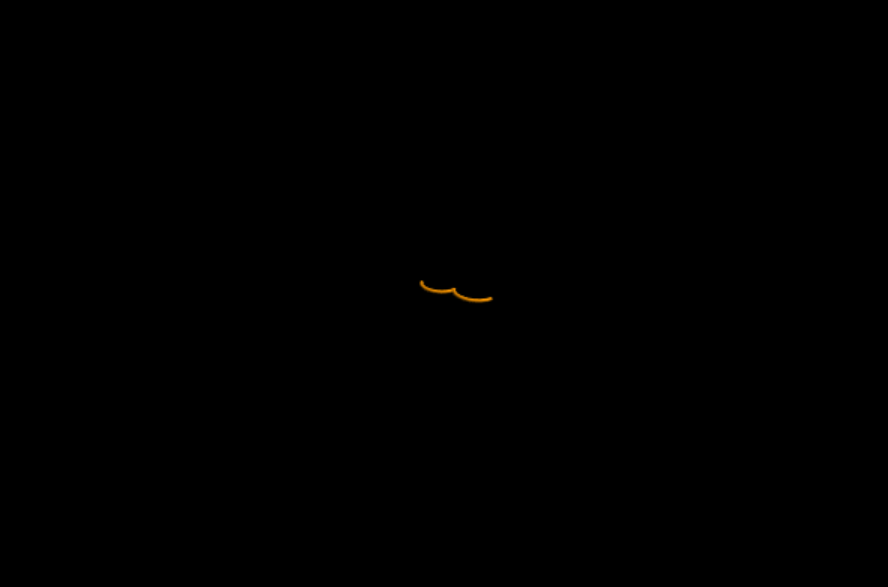

Below is an example of the trajectory when the center of mass is taken into account.



2. Now we vary the time step over several orders of magnitude and monitor the energy conservation laws. For the original value (dt = 0.001), it appears as if the conservation of energy doesn't hold, as the total energy keeps increasing. 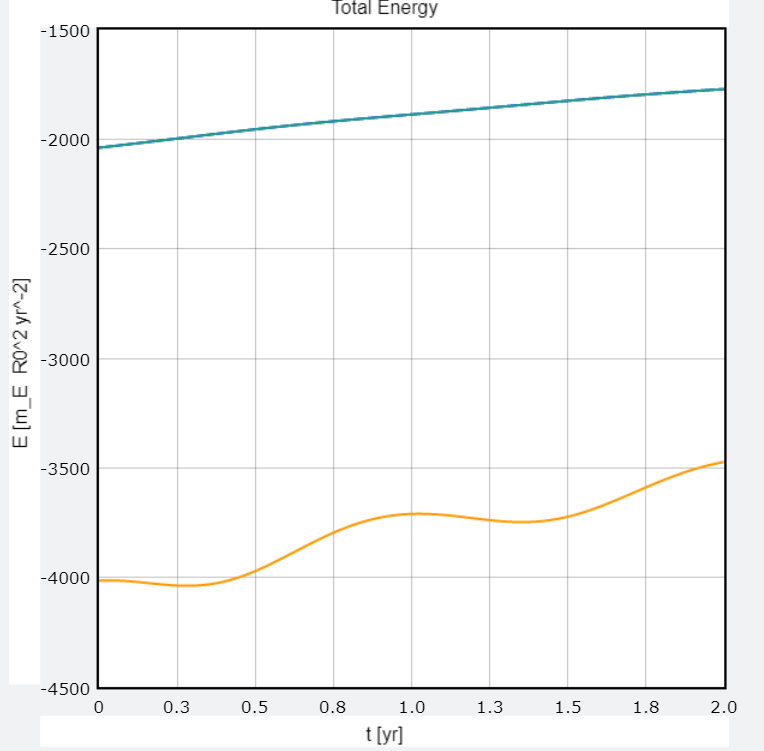
If the time step increases to 0.00001, the total energy for the planet stays fairly constant. However, this it not true for the energy of the sun. 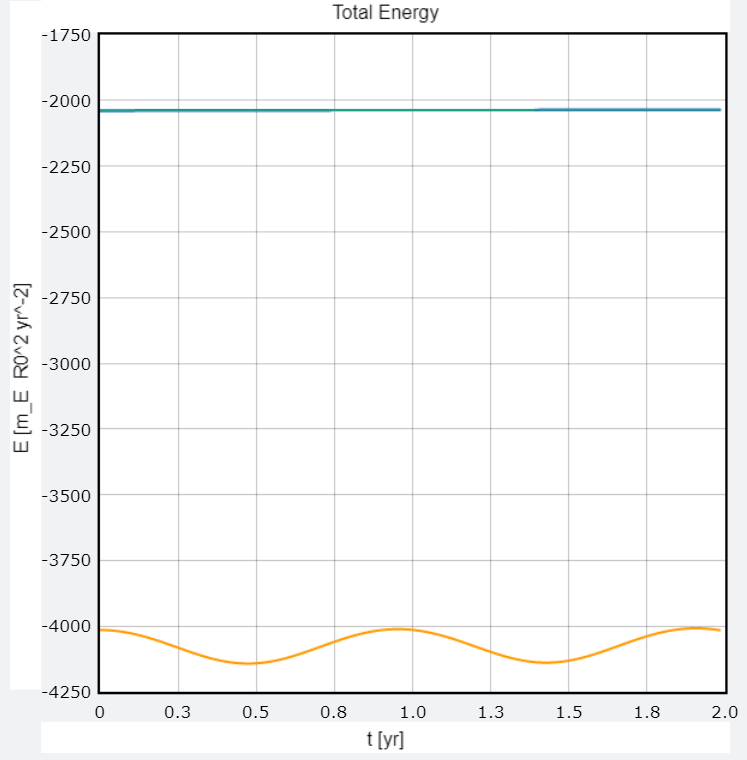
The simulation, as well as the total energy graph, seems to get progressively worse as the time step decreases.

It would also be worth it to check that the angular momentum is consverved as well.

3. Below is an image of what happens when $\alpha = \beta = 20$. I cannot seem to figure out why the trajectories of mercury and earth are crossing.
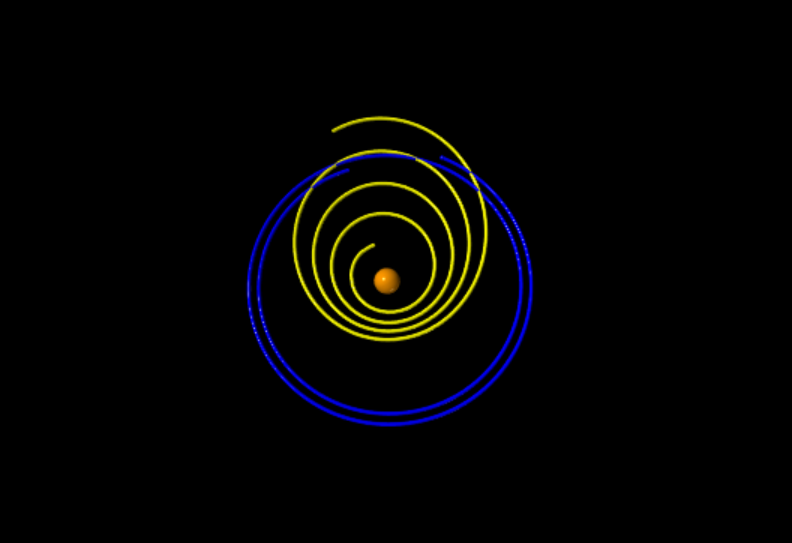

4. 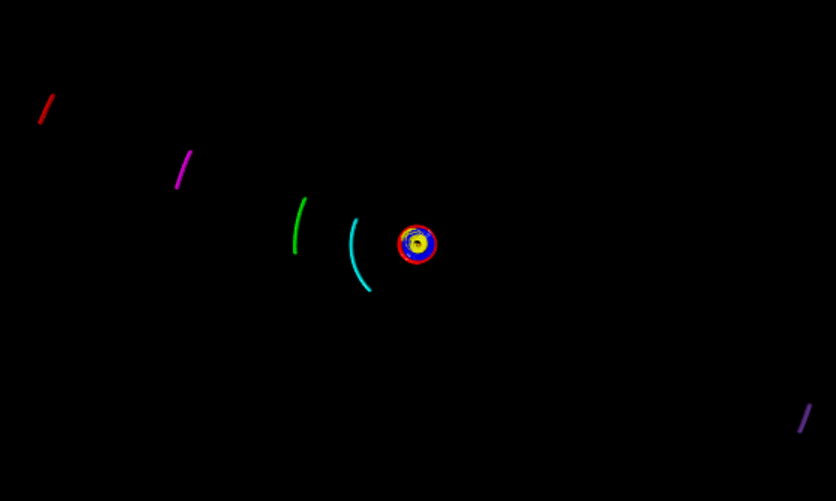
 


In [1]:

# set up the VPython scene
scene = canvas(title='Solar System',
            width=600, height=400,
            center=vector(0,0,0), background=color.black)

# For some reason, the creators thought it would be a good idea to have y be the
# upward direction. We'll change that to the z direction.
scene.forward = vector(1,0,0)
scene.up = vector(0,0,1)

# Define and initiate the simulated objects - remember to translate to natural units!
sun     = AstroObject(G, 
                      mass = 1.99*10**30/m0, 
                      pos=vector(0,0,0),
                      velocity=vector(0,0,0), 
                      color=color.orange, radius=1)

earth   = AstroObject(G, 
                      mass = 5.97*10**24/m0, 
                      pos=vector(147.1*10**9/R0,0,0), 
                      velocity=vector(0,29800*t0/R0,0), 
                      color=color.blue, radius=0.2)

mercury   = AstroObject(G, 
                      mass = 0.330*10**24/m0, 
                      pos=vector(46*10**9/R0,0,0), 
                      velocity=vector(0,47400*t0/R0,0), 
                      color=color.yellow, radius=0.2)

venus   = AstroObject(G, 
                      mass = 4.87*10**24/m0, 
                      pos=vector(107.5*10**9/R0,0,0), 
                      velocity=vector(0,35000*t0/R0,0), 
                      color=color.blue, radius=0.2)

mars   = AstroObject(G, 
                      mass = 0.642*10**24/m0, 
                      pos=vector(206.6*10**9/R0,0,0), 
                      velocity=vector(0,24100*t0/R0,0), 
                      color=color.red, radius=0.2)

jupiter   = AstroObject(G, 
                      mass = 1898*10**24/m0, 
                      pos=vector(740.5*10**9/R0,0,0), 
                      velocity=vector(0,13100*t0/R0,0), 
                      color=color.cyan, radius=0.2)

saturn   = AstroObject(G, 
                      mass = 568*10**24/m0, 
                      pos=vector(147.1*10**9/R0,0,0), 
                      velocity=vector(0,9700*t0/R0,0), 
                      color=color.green, radius=0.2)

uranus   = AstroObject(G, 
                      mass = 86.8*10**24/m0, 
                      pos=vector(2741.3*10**9/R0,0,0), 
                      velocity=vector(0,6800*t0/R0,0), 
                      color=color.magenta, radius=0.2)

neptune   = AstroObject(G, 
                      mass = 102*10**24/m0, 
                      pos=vector(4444.5*10**9/R0,0,0), 
                      velocity=vector(0,5400*t0/R0,0), 
                      color=color.red, radius=0.2)

pluto   = AstroObject(G, 
                      mass = 0.0146*10**24/m0, 
                      pos=vector(4436.8*10**9/R0,0,0), 
                      velocity=vector(0,4700*t0/R0,0), 
                      color=color.purple, radius=0.2)



# Create the list of objects and initiate the simulator.
objects=[sun, earth,mercury, venus, mars, jupiter, saturn, uranus, neptune, pluto]
sim = Simulator(objects, G, 0.001)


# Choose the time span of the simulation (in years).
tmax = 2


# Create a VPython graph object for the potential energy.
vgraph = graph(x=800, y=0,width=600,height=600,\
              title = 'Potential Energy', \
              xtitle = 't [yr]', ytitle = 'V [m_E  R0^2 yr^-2]', \
              foreground = color.black, background =color.white, \
              xmax = tmax, xmin = 0)

# All subsequently defined VPython curve objects are children of the
# same graph until the next graph object is created.
vcurves=[ ]
for obj in objects:
	vcurves.append(gcurve(color=obj.color))

# Same graph for the kinetic energy...
tgraph = graph(x=800, y=0,width=600,height=600,\
                  title = 'Kinetic Energy (radial + angular)', \
                  xtitle = 't [yr]', ytitle = 'T [m_E  R0^2 yr^-2]', \
              foreground = color.black, background =color.white, \
              xmax = tmax, xmin = 0)

tcurves=[ ]
for obj in objects:
	tcurves.append(gcurve(color=obj.color))


# ... and the total energy.
egraph = graph(x=800, y=0,width=600,height=600,\
                  title = 'Total Energy', \
                  xtitle = 't [yr]', ytitle = 'E [m_E  R0^2 yr^-2]', \
              foreground = color.black, background =color.white, \
              xmax = tmax, xmin = 0)

ecurves=[ ]
for obj in objects:
	ecurves.append(gcurve(color=obj.color))

# We add one curve that contains the total energy of the entire system.
ecurves.append(gcurve(color=vector(31,158,137)/255.))


# Initialize step counter...
steps = 0

# ... and start the simulation.
while steps * sim.dt < tmax:

	# VPython animation rate.
	rate(100)
	
	# Take a time step.
	sim.update_euler()

	# Update energy graphs.
	totE = 0
	for i, obj in enumerate(objects):
		# if obj == earth:
		tcurves[i].plot(steps*sim.dt, obj.T)
		vcurves[i].plot(steps*sim.dt, obj.V)
		ecurves[i].plot(steps*sim.dt, obj.V + obj.T)
		totE += obj.T + 0.5*obj.V

	ecurves[-1].plot(steps*sim.dt, totE)
        
	steps+=1




NameError: name 'canvas' is not defined